In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import IPython
import IPython.display
import pandas as pd
import numpy as np
import math
import scipy
import tempfile
import statsmodels.formula.api as smf
import statsmodels.api as sm
import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, MinMaxScaler

# Make numpcy values easier to read.
np.set_printoptions(precision=3, suppress=True)

import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras import layers
from tensorflow.keras.utils import to_categorical #type: ignore
import matplotlib.pyplot as plt
import matplotlib as mat
#import colordict as cd
import seaborn as sns

from flowability_data_upload.Research import main
from flowability_data_upload.Research.main import trymodel, makemodel, modeltest

from statsmodels.graphics.regressionplots import abline_plot

from flowability_data_upload.Research.main import trymodel, makemodel, modeltest, Data

import matplotlib.pyplot as plt
from matplotlib import cm  
from mpl_toolkits.mplot3d import Axes3D


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
%matplotlib inline  
%matplotlib notebook

In [3]:
%%capture

def load_data():
    x = Data()
    x.importnewpowders()
    df_data = pd.DataFrame(x.data)
    df_flow = pd.DataFrame(x.flow)
    df_noflow = pd.DataFrame(x.noflow)

    return df_data, df_flow, df_noflow

df_data, df_flow, df_noflow = load_data()

In [4]:
pd.set_option('display.max_columns', None)
df_data.describe()

,Da,Dp,FWidth,FLength,ELength,EWidth,Volume,Area,Perimeter,CHull Area,CHull Perimeter,Sphericity,Compactness,Roundness,Ellipse Ratio,Circularity,Solidity,Concavity,Convexity,Extent,Transparency,Curvature,Surface Area,L/W Ratio,W/L Aspect Ratio,CHull Surface Area,Ellipticity,Flow,Flow Class
count,271433.000000,271433.000000,271433.000000,271433.000000,271433.000000,271433.000000,2.714330e+05,271433.000000,271433.000000,271433.000000,271433.000000,271433.000000,271433.000000,271433.000000,271433.000000,271433.000000,271433.000000,271433.000000,271433.000000,271433.000000,271433.000000,271433.000000,271433.000000,271433.000000,271433.000000,271433.000000,271433.000000,271433.000000,271433.000000
mean,17.437426,19.584505,16.006094,20.989617,20.064784,15.574809,1.194712e+04,394.803286,61.526533,417.306852,58.768829,0.899650,0.831908,0.699995,0.794656,0.813635,0.944927,0.055073,0.969058,0.711475,0.369702,0.030291,1579.213144,1.348371,0.769345,1669.227407,1.321048,17.321739,0.557965
std,14.093120,16.539802,12.996290,17.264877,17.008509,12.737594,8.588047e+04,897.617276,51.961316,966.819265,47.467115,0.065308,0.089029,0.141272,0.148346,0.112077,0.046066,0.046066,0.034497,0.052250,0.059026,0.205644,3590.469105,0.303105,0.129415,3867.277062,0.359398,19.867035,0.496630
min,2.579000,3.620000,3.000000,3.840000,2.950000,2.067000,8.985000e+00,5.225000,11.373000,7.423000,11.046000,0.435000,0.291000,0.084000,0.098000,0.189000,0.700000,0.000000,0.548000,0.380000,0.000000,0.000000,20.900000,1.015000,0.124000,29.692000,1.000000,0.000000,0.000000
25%,8.120000,8.978000,7.462000,9.802000,9.166000,7.170000,2.803440e+02,51.787000,28.206000,54.896000,27.675000,0.867000,0.780000,0.608000,0.709000,0.752000,0.928000,0.024000,0.959000,0.686000,0.333000,0.000000,207.147000,1.150000,0.693000,219.583000,1.097000,0.000000,0.000000
50%,12.486000,13.765000,11.378000,14.978000,14.183000,11.128000,1.019258e+03,122.447000,43.244000,129.397000,42.106000,0.917000,0.850000,0.722000,0.832000,0.841000,0.958000,0.042000,0.982000,0.722000,0.383000,0.000000,489.787000,1.255000,0.797000,517.590000,1.201000,14.430000,1.000000
75%,22.466000,24.995000,20.670000,26.623000,25.589000,20.080000,5.936972e+03,396.400000,78.524000,419.254000,75.287000,0.949000,0.900000,0.810000,0.911000,0.900000,0.976000,0.072000,0.992000,0.748000,0.416000,0.000000,1585.602000,1.442000,0.869000,1677.015000,1.410000,34.310000,1.000000
max,395.289000,841.622000,375.143000,514.872000,473.644000,371.279000,3.234010e+07,122720.860000,2644.034000,145923.674000,1448.384000,0.993000,0.987000,0.974000,1.000000,0.986000,1.000000,0.300000,1.000000,0.894000,0.674000,6.250000,490883.440000,8.085000,0.985000,583694.696000,10.246000,64.303333,1.000000


# Training Classifiers

## Flow Class Prediction

In [5]:
#Flow Class Imbalance

neg, pos = np.bincount(df_data['Flow Class']) #type: ignore
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 271433
    Positive: 151450 (55.80% of total)



### Data Cleaning

In [6]:
cleaned_df = df_data.copy().reset_index(drop = True)

powder = cleaned_df.pop('Flow')
powder = cleaned_df.pop('Powder')

## Model Class

In [7]:
class Model:
    def __init__(self, name, num_classes = 2):
        self.name = name
        self.num_classes = num_classes

        self.EPOCHS = 100
        self.BATCH_SIZE = 2048
        

In [8]:
regular_model = Model(name = "Regular")
boxcox_model = Model(name="Boxcox Transform")

### Train Test Split

In [9]:
def split_transform_data(self, cleaned_df, target = 'Flow Class', use_boxcox = False):
    # Use a utility from sklearn to split and shuffle your dataset.
    train_df, self.test_df = train_test_split(cleaned_df, test_size=0.2)

    if use_boxcox:
        for col in train_df.columns[:-1]: #all except last (assuming target)
            fit_values, fit_lambda = scipy.stats.boxcox(train_df[col].values + 0.0001)
            train_df[col] = fit_values
            self.test_df[col] = scipy.stats.boxcox(self.test_df[col].values + 0.0001, fit_lambda)

    self.train_df, self.val_df = train_test_split(train_df, test_size=0.2)

    # Form np arrays of labels and features.
    self.train_labels = np.array(self.train_df.pop(target))
    self.bool_train_labels = self.train_labels != 0
    self.val_labels = np.array(self.val_df.pop(target))
    self.test_labels = np.array(self.test_df.pop(target))

    self.train_features = np.array(self.train_df)
    self.val_features = np.array(self.val_df)
    self.test_features = np.array(self.test_df)
      

Model.split_transform_data = split_transform_data

In [10]:
regular_model.split_transform_data(cleaned_df, use_boxcox=False)
boxcox_model.split_transform_data(cleaned_df, use_boxcox=True)

### Apply Standard Scaling

In [11]:
def apply_StandardScaler(self):
    scaler = MinMaxScaler()
    self.train_features = scaler.fit_transform(self.train_features)

    self.val_features = scaler.transform(self.val_features)
    self.test_features = scaler.transform(self.test_features)

    self.train_features = np.clip(self.train_features, -5, 5)
    self.val_features = np.clip(self.val_features, -5, 5)
    self.test_features = np.clip(self.test_features, -5, 5)


    print('Training labels shape:', self.train_labels.shape)
    print('Validation labels shape:', self.val_labels.shape)
    print('Test labels shape:', self.test_labels.shape)

    print('Training features shape:', self.train_features.shape)
    print('Validation features shape:', self.val_features.shape)
    print('Test features shape:', self.test_features.shape)

Model.apply_StandardScaler = apply_StandardScaler

In [12]:
regular_model.apply_StandardScaler()
boxcox_model.apply_StandardScaler()

Training labels shape: (173716,)
Validation labels shape: (43430,)
Test labels shape: (54287,)
Training features shape: (173716, 27)
Validation features shape: (43430, 27)
Test features shape: (54287, 27)
Training labels shape: (173716,)
Validation labels shape: (43430,)
Test labels shape: (54287,)
Training features shape: (173716, 27)
Validation features shape: (43430, 27)
Test features shape: (54287, 27)


### Define Model and Metrics

In [13]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

Model.METRICS = METRICS

def make_model(self, output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    self.model = keras.Sequential([
      keras.layers.Dense(
          16, activation='relu',
          input_shape=(self.train_features.shape[-1],)),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=output_bias),
  ])

    self.model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=self.METRICS)

    return self.model

Model.make_model = make_model

def evaluate_model(self):
    results = self.model.evaluate(self.train_features, self.train_labels, batch_size = self.BATCH_SIZE, verbose=0)
    print("Loss: {:0.4f}".format(results[0]))

Model.evaluate_model = evaluate_model

def fit_model(self):

    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_prc', 
        verbose=1,
        patience=10,
        mode='max',
        restore_best_weights=True)

    self.history = self.model.fit(
        self.train_features,
        self.train_labels,
        batch_size=self.BATCH_SIZE,
        epochs=self.EPOCHS,
        callbacks=[early_stopping],
        validation_data=(self.val_features, self.val_labels))

    return self.history

Model.fit_model = fit_model

def predict(self, input):
    # make predictions on the input data using the model
    scaler = StandardScaler()
    scaled_input = scaler.fit_transform(input)

    predictions = self.model.predict(scaled_input)
    
    return predictions

Model.predict = predict
  
def create_model():

    model = keras.Sequential([
      keras.layers.Dense(
          16, activation='relu',
          input_shape=(27,)),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(1, activation='sigmoid'),
  ])

    model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=METRICS)

    return model

2022-12-16 03:18:18.970848: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Visualization

In [14]:
def visualize(self):
    pos_df = pd.DataFrame(self.train_features[self.bool_train_labels], columns=self.train_df.columns)
    neg_df = pd.DataFrame(self.train_features[~self.bool_train_labels], columns=self.train_df.columns)

    f1,f2 = np.random.choice(self.train_df.columns, 2, replace=False)

    sns.jointplot(x=pos_df[f1], y=pos_df[f2],
                kind='hex', xlim=(-5,5), ylim=(-5,5))
    plt.suptitle("Positive distribution")

    sns.jointplot(x=neg_df[f1], y=neg_df[f2],
                kind='hex', xlim=(-5,5), ylim=(-5,5))
    _ = plt.suptitle("Negative distribution")

Model.visualize = visualize

def plot_metrics(self):

    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

    metrics = ['loss', 'prc', 'precision', 'recall']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(self.history.epoch, self.history.history[metric], color=colors[0], label='Train')
        plt.plot(self.history.epoch, self.history.history['val_'+metric],
                 color=colors[0], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([0.8,1])
        else:
            plt.ylim([0,1])

    plt.legend()

Model.plot_metrics = plot_metrics

def plot_cm(self, p=0.5):
    predictions = self.model.predict(self.test_features)
    cm = confusion_matrix(self.test_labels, predictions > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    print('No Flow Detected (True Negatives): ', cm[0][0])
    print('Flow Incorrectly Detected (False Positives): ', cm[0][1])
    print('No Flow Incorrectly Detected (False Negatives): ', cm[1][0])
    print('Flow Detected (True Positives): ', cm[1][1])
    print('Total Flow Detected: ', np.sum(cm[1]))

    print((cm[0][0] + cm[1][1]) / (cm[0][0] +  cm[0][1] + cm[1][0] +cm[1][1]))

Model.plot_cm = plot_cm

## Baseline Model

In [15]:
baseline = Model(name = "Baseline Model", num_classes= 2)

baseline.split_transform_data(cleaned_df, use_boxcox=False)

baseline.apply_StandardScaler()

Training labels shape: (173716,)
Validation labels shape: (43430,)
Test labels shape: (54287,)
Training features shape: (173716, 27)
Validation features shape: (43430, 27)
Test features shape: (54287, 27)


In [16]:
first_model = baseline.make_model()
history = baseline.fit_model()
baseline.evaluate_model()

Epoch 1/100
85/85 [==============================] - 2s 11ms/step - loss: 0.7193 - tp: 72426.0000 - fp: 55497.0000 - tn: 21265.0000 - fn: 24528.0000 - accuracy: 0.5393 - precision: 0.5662 - recall: 0.7470 - auc: 0.5233 - prc: 0.5771 - val_loss: 0.6653 - val_tp: 24341.0000 - val_fp: 19089.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.5605 - val_precision: 0.5605 - val_recall: 1.0000 - val_auc: 0.7334 - val_prc: 0.7784
Epoch 2/100
85/85 [==============================] - 0s 2ms/step - loss: 0.6676 - tp: 81786.0000 - fp: 57003.0000 - tn: 19759.0000 - fn: 15168.0000 - accuracy: 0.5845 - precision: 0.5893 - recall: 0.8436 - auc: 0.6113 - prc: 0.6676 - val_loss: 0.6426 - val_tp: 23868.0000 - val_fp: 18007.0000 - val_tn: 1082.0000 - val_fn: 473.0000 - val_accuracy: 0.5745 - val_precision: 0.5700 - val_recall: 0.9806 - val_auc: 0.7301 - val_prc: 0.7804
Epoch 3/100
85/85 [==============================] - 0s 2ms/step - loss: 0.6455 - tp: 80457.0000 - fp: 50939.0000 - tn: 2582

Epoch 20/100
85/85 [==============================] - 0s 2ms/step - loss: 0.5874 - tp: 72624.0000 - fp: 27727.0000 - tn: 49035.0000 - fn: 24330.0000 - accuracy: 0.7003 - precision: 0.7237 - recall: 0.7491 - auc: 0.7558 - prc: 0.7903 - val_loss: 0.5775 - val_tp: 17573.0000 - val_fp: 5781.0000 - val_tn: 13308.0000 - val_fn: 6768.0000 - val_accuracy: 0.7111 - val_precision: 0.7525 - val_recall: 0.7220 - val_auc: 0.7628 - val_prc: 0.7971
Epoch 21/100
85/85 [==============================] - 0s 2ms/step - loss: 0.5875 - tp: 72706.0000 - fp: 27583.0000 - tn: 49179.0000 - fn: 24248.0000 - accuracy: 0.7016 - precision: 0.7250 - recall: 0.7499 - auc: 0.7560 - prc: 0.7904 - val_loss: 0.5767 - val_tp: 17572.0000 - val_fp: 5782.0000 - val_tn: 13307.0000 - val_fn: 6769.0000 - val_accuracy: 0.7110 - val_precision: 0.7524 - val_recall: 0.7219 - val_auc: 0.7632 - val_prc: 0.7975
Epoch 22/100
85/85 [==============================] - 0s 2ms/step - loss: 0.5858 - tp: 72630.0000 - fp: 27495.0000 - tn: 492

Epoch 39/100
85/85 [==============================] - 0s 2ms/step - loss: 0.5822 - tp: 73898.0000 - fp: 28175.0000 - tn: 48587.0000 - fn: 23056.0000 - accuracy: 0.7051 - precision: 0.7240 - recall: 0.7622 - auc: 0.7623 - prc: 0.7956 - val_loss: 0.5709 - val_tp: 17958.0000 - val_fp: 5961.0000 - val_tn: 13128.0000 - val_fn: 6383.0000 - val_accuracy: 0.7158 - val_precision: 0.7508 - val_recall: 0.7378 - val_auc: 0.7683 - val_prc: 0.8018
Epoch 40/100
85/85 [==============================] - 0s 2ms/step - loss: 0.5829 - tp: 74046.0000 - fp: 28276.0000 - tn: 48486.0000 - fn: 22908.0000 - accuracy: 0.7054 - precision: 0.7237 - recall: 0.7637 - auc: 0.7618 - prc: 0.7951 - val_loss: 0.5712 - val_tp: 18081.0000 - val_fp: 6086.0000 - val_tn: 13003.0000 - val_fn: 6260.0000 - val_accuracy: 0.7157 - val_precision: 0.7482 - val_recall: 0.7428 - val_auc: 0.7685 - val_prc: 0.8020
Epoch 41/100
85/85 [==============================] - 0s 2ms/step - loss: 0.5824 - tp: 73997.0000 - fp: 28133.0000 - tn: 486

Epoch 58/100
85/85 [==============================] - 0s 2ms/step - loss: 0.5809 - tp: 74195.0000 - fp: 28155.0000 - tn: 48607.0000 - fn: 22759.0000 - accuracy: 0.7069 - precision: 0.7249 - recall: 0.7653 - auc: 0.7638 - prc: 0.7971 - val_loss: 0.5697 - val_tp: 18055.0000 - val_fp: 5955.0000 - val_tn: 13134.0000 - val_fn: 6286.0000 - val_accuracy: 0.7181 - val_precision: 0.7520 - val_recall: 0.7418 - val_auc: 0.7705 - val_prc: 0.8034
Epoch 59/100
85/85 [==============================] - 0s 2ms/step - loss: 0.5812 - tp: 74227.0000 - fp: 28199.0000 - tn: 48563.0000 - fn: 22727.0000 - accuracy: 0.7068 - precision: 0.7247 - recall: 0.7656 - auc: 0.7637 - prc: 0.7969 - val_loss: 0.5694 - val_tp: 18244.0000 - val_fp: 6202.0000 - val_tn: 12887.0000 - val_fn: 6097.0000 - val_accuracy: 0.7168 - val_precision: 0.7463 - val_recall: 0.7495 - val_auc: 0.7704 - val_prc: 0.8035
Epoch 60/100
85/85 [==============================] - 0s 2ms/step - loss: 0.5819 - tp: 74202.0000 - fp: 28118.0000 - tn: 486

Epoch 77/100
85/85 [==============================] - 0s 2ms/step - loss: 0.5802 - tp: 74486.0000 - fp: 28225.0000 - tn: 48537.0000 - fn: 22468.0000 - accuracy: 0.7082 - precision: 0.7252 - recall: 0.7683 - auc: 0.7652 - prc: 0.7979 - val_loss: 0.5681 - val_tp: 18078.0000 - val_fp: 5932.0000 - val_tn: 13157.0000 - val_fn: 6263.0000 - val_accuracy: 0.7192 - val_precision: 0.7529 - val_recall: 0.7427 - val_auc: 0.7715 - val_prc: 0.8044
Epoch 78/100
85/85 [==============================] - 0s 2ms/step - loss: 0.5795 - tp: 74351.0000 - fp: 28099.0000 - tn: 48663.0000 - fn: 22603.0000 - accuracy: 0.7081 - precision: 0.7257 - recall: 0.7669 - auc: 0.7655 - prc: 0.7983 - val_loss: 0.5695 - val_tp: 18270.0000 - val_fp: 6176.0000 - val_tn: 12913.0000 - val_fn: 6071.0000 - val_accuracy: 0.7180 - val_precision: 0.7474 - val_recall: 0.7506 - val_auc: 0.7716 - val_prc: 0.8043
Epoch 79/100
85/85 [==============================] - 0s 2ms/step - loss: 0.5804 - tp: 74439.0000 - fp: 28189.0000 - tn: 485

Epoch 96/100
85/85 [==============================] - 0s 2ms/step - loss: 0.5791 - tp: 74468.0000 - fp: 27829.0000 - tn: 48933.0000 - fn: 22486.0000 - accuracy: 0.7104 - precision: 0.7280 - recall: 0.7681 - auc: 0.7662 - prc: 0.7983 - val_loss: 0.5678 - val_tp: 17841.0000 - val_fp: 5627.0000 - val_tn: 13462.0000 - val_fn: 6500.0000 - val_accuracy: 0.7208 - val_precision: 0.7602 - val_recall: 0.7330 - val_auc: 0.7718 - val_prc: 0.8045
Epoch 97/100
85/85 [==============================] - 0s 2ms/step - loss: 0.5798 - tp: 74450.0000 - fp: 28035.0000 - tn: 48727.0000 - fn: 22504.0000 - accuracy: 0.7091 - precision: 0.7264 - recall: 0.7679 - auc: 0.7657 - prc: 0.7976 - val_loss: 0.5685 - val_tp: 18342.0000 - val_fp: 6244.0000 - val_tn: 12845.0000 - val_fn: 5999.0000 - val_accuracy: 0.7181 - val_precision: 0.7460 - val_recall: 0.7535 - val_auc: 0.7720 - val_prc: 0.8048
Epoch 98/100
85/85 [==============================] - 0s 2ms/step - loss: 0.5793 - tp: 74461.0000 - fp: 27911.0000 - tn: 488

<IPython.core.display.Javascript object>


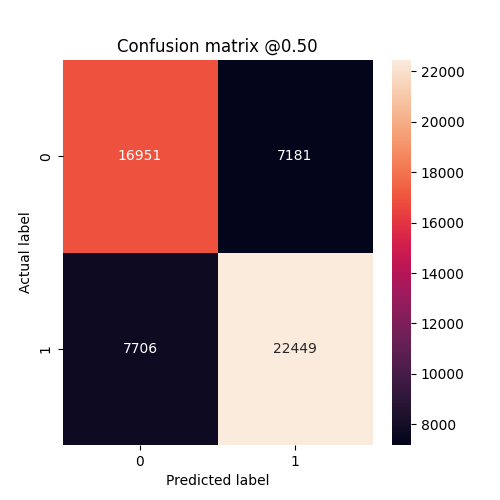

No Flow Detected (True Negatives):  16951
Flow Incorrectly Detected (False Positives):  7181
No Flow Incorrectly Detected (False Negatives):  7706
Flow Detected (True Positives):  22449
Total Flow Detected:  30155
0.725772284340634


In [17]:
baseline.plot_cm()

### Resampling

In [18]:
def resample(df_data, target = "Powder", n = 10000):
    grouped_df = df_data.groupby('Powder')
    # create a new dataframe to hold the resampled rows
    resampled_df = pd.DataFrame()

    # for each group in the grouped dataframe
    for name, group in grouped_df:
        # if the number of rows in the group is greater than n
        if len(group) > n:
            # undersample the group without replacement
            resampled_group = group.sample(n=n, replace=False)
        else:
            # oversample the group with replacement
            resampled_group = group.sample(n=n, replace=True)
        # append the resampled group to the resampled dataframe
        resampled_df = pd.concat([resampled_df, resampled_group], axis = 0)

    # print the resampled dataframe
    resampled_df = resampled_df.reset_index(drop = True)

    return resampled_df

In [19]:
resampled_df = resample(df_data)


le = LabelEncoder()
resampled_df['Powder Class'] = le.fit_transform(resampled_df['Powder'])#type: ignore
num_classes = len(le.classes_)
counts = np.bincount(resampled_df['Powder Class']) 
total = sum(counts)

for label,count in zip(le.classes_,counts):
    print(f"Label {label} : {count} ({count/total * 100:.2f}% of total)")
    break

resampled_df.pop('Powder')
resampled_df.pop('Flow Class')
resampled_df.pop('Flow')

class_labels = resampled_df.pop('Powder Class')

Label AEE_WP-301_1-5_AA_3-7.txt : 10000 (3.03% of total)


## Flow Class Resample

In [20]:
powder_balanced_df = resample(df_data)

powder_balanced_df.pop("Powder")
powder_balanced_df.pop("Flow")

neg, pos = np.bincount(powder_balanced_df['Flow Class']) #type: ignore
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 330000
    Positive: 240000 (72.73% of total)



In [21]:
balanced_model = Model(name = "Balanced Model", num_classes= 2)

balanced_model.split_transform_data(powder_balanced_df)

balanced_model.apply_StandardScaler()

Training labels shape: (211200,)
Validation labels shape: (52800,)
Test labels shape: (66000,)
Training features shape: (211200, 27)
Validation features shape: (52800, 27)
Test features shape: (66000, 27)


In [22]:
model = balanced_model.make_model()
history = balanced_model.fit_model()
# IPython.display.clear_output()
balanced_model.evaluate_model()

Epoch 1/100
104/104 [==============================] - 2s 10ms/step - loss: 0.7324 - tp: 161771.0000 - fp: 54675.0000 - tn: 79699.0000 - fn: 88771.0000 - accuracy: 0.6273 - precision: 0.7474 - recall: 0.6457 - auc: 0.6533 - prc: 0.7736 - val_loss: 0.5560 - val_tp: 38335.0000 - val_fp: 14186.0000 - val_tn: 195.0000 - val_fn: 84.0000 - val_accuracy: 0.7297 - val_precision: 0.7299 - val_recall: 0.9978 - val_auc: 0.7203 - val_prc: 0.8812
Epoch 2/100
104/104 [==============================] - 0s 2ms/step - loss: 0.6133 - tp: 128690.0000 - fp: 44605.0000 - tn: 13007.0000 - fn: 24898.0000 - accuracy: 0.6709 - precision: 0.7426 - recall: 0.8379 - auc: 0.5820 - prc: 0.7912 - val_loss: 0.5394 - val_tp: 38222.0000 - val_fp: 13930.0000 - val_tn: 451.0000 - val_fn: 197.0000 - val_accuracy: 0.7324 - val_precision: 0.7329 - val_recall: 0.9949 - val_auc: 0.7548 - val_prc: 0.8993
Epoch 3/100
104/104 [==============================] - 0s 2ms/step - loss: 0.5922 - tp: 131490.0000 - fp: 45358.0000 - tn: 1

Epoch 20/100
104/104 [==============================] - 0s 2ms/step - loss: 0.4849 - tp: 131542.0000 - fp: 32570.0000 - tn: 25042.0000 - fn: 22046.0000 - accuracy: 0.7414 - precision: 0.8015 - recall: 0.8565 - auc: 0.7729 - prc: 0.9070 - val_loss: 0.4641 - val_tp: 33879.0000 - val_fp: 8380.0000 - val_tn: 6001.0000 - val_fn: 4540.0000 - val_accuracy: 0.7553 - val_precision: 0.8017 - val_recall: 0.8818 - val_auc: 0.7938 - val_prc: 0.9189
Epoch 21/100
104/104 [==============================] - 0s 2ms/step - loss: 0.4841 - tp: 132408.0000 - fp: 33295.0000 - tn: 24317.0000 - fn: 21180.0000 - accuracy: 0.7421 - precision: 0.7991 - recall: 0.8621 - auc: 0.7739 - prc: 0.9075 - val_loss: 0.4635 - val_tp: 34442.0000 - val_fp: 8932.0000 - val_tn: 5449.0000 - val_fn: 3977.0000 - val_accuracy: 0.7555 - val_precision: 0.7941 - val_recall: 0.8965 - val_auc: 0.7936 - val_prc: 0.9189
Epoch 22/100
104/104 [==============================] - 0s 2ms/step - loss: 0.4831 - tp: 133960.0000 - fp: 34636.0000 - 

Epoch 39/100
104/104 [==============================] - 0s 2ms/step - loss: 0.4740 - tp: 144979.0000 - fp: 45479.0000 - tn: 12133.0000 - fn: 8609.0000 - accuracy: 0.7439 - precision: 0.7612 - recall: 0.9439 - auc: 0.7808 - prc: 0.9125 - val_loss: 0.4607 - val_tp: 36677.0000 - val_fp: 11409.0000 - val_tn: 2972.0000 - val_fn: 1742.0000 - val_accuracy: 0.7509 - val_precision: 0.7627 - val_recall: 0.9547 - val_auc: 0.7968 - val_prc: 0.9200
Epoch 40/100
104/104 [==============================] - 0s 2ms/step - loss: 0.4744 - tp: 144931.0000 - fp: 45306.0000 - tn: 12306.0000 - fn: 8657.0000 - accuracy: 0.7445 - precision: 0.7618 - recall: 0.9436 - auc: 0.7802 - prc: 0.9122 - val_loss: 0.4604 - val_tp: 36547.0000 - val_fp: 11233.0000 - val_tn: 3148.0000 - val_fn: 1872.0000 - val_accuracy: 0.7518 - val_precision: 0.7649 - val_recall: 0.9513 - val_auc: 0.7968 - val_prc: 0.9200
Epoch 41/100
104/104 [==============================] - 0s 2ms/step - loss: 0.4737 - tp: 144773.0000 - fp: 44983.0000 - 

Epoch 58/100
104/104 [==============================] - 0s 2ms/step - loss: 0.4714 - tp: 144517.0000 - fp: 44401.0000 - tn: 13211.0000 - fn: 9071.0000 - accuracy: 0.7468 - precision: 0.7650 - recall: 0.9409 - auc: 0.7831 - prc: 0.9139 - val_loss: 0.4577 - val_tp: 36396.0000 - val_fp: 11038.0000 - val_tn: 3343.0000 - val_fn: 2023.0000 - val_accuracy: 0.7526 - val_precision: 0.7673 - val_recall: 0.9473 - val_auc: 0.7984 - val_prc: 0.9207
Epoch 59/100
104/104 [==============================] - 0s 2ms/step - loss: 0.4704 - tp: 144647.0000 - fp: 44658.0000 - tn: 12954.0000 - fn: 8941.0000 - accuracy: 0.7462 - precision: 0.7641 - recall: 0.9418 - auc: 0.7837 - prc: 0.9142 - val_loss: 0.4574 - val_tp: 36163.0000 - val_fp: 10737.0000 - val_tn: 3644.0000 - val_fn: 2256.0000 - val_accuracy: 0.7539 - val_precision: 0.7711 - val_recall: 0.9413 - val_auc: 0.7987 - val_prc: 0.9208
Epoch 60/100
104/104 [==============================] - 0s 2ms/step - loss: 0.4708 - tp: 144549.0000 - fp: 44712.0000 - 

Epoch 77/100
104/104 [==============================] - 0s 2ms/step - loss: 0.4692 - tp: 144109.0000 - fp: 43948.0000 - tn: 13664.0000 - fn: 9479.0000 - accuracy: 0.7470 - precision: 0.7663 - recall: 0.9383 - auc: 0.7860 - prc: 0.9151 - val_loss: 0.4563 - val_tp: 35962.0000 - val_fp: 10407.0000 - val_tn: 3974.0000 - val_fn: 2457.0000 - val_accuracy: 0.7564 - val_precision: 0.7756 - val_recall: 0.9360 - val_auc: 0.7993 - val_prc: 0.9210
Epoch 78/100
104/104 [==============================] - 0s 2ms/step - loss: 0.4688 - tp: 144156.0000 - fp: 43976.0000 - tn: 13636.0000 - fn: 9432.0000 - accuracy: 0.7471 - precision: 0.7662 - recall: 0.9386 - auc: 0.7862 - prc: 0.9153 - val_loss: 0.4564 - val_tp: 35814.0000 - val_fp: 10260.0000 - val_tn: 4121.0000 - val_fn: 2605.0000 - val_accuracy: 0.7563 - val_precision: 0.7773 - val_recall: 0.9322 - val_auc: 0.7993 - val_prc: 0.9210
Epoch 79/100
104/104 [==============================] - 0s 2ms/step - loss: 0.4682 - tp: 144121.0000 - fp: 43810.0000 - 

In [23]:
# import kerastuner as kt

# def model_builder(hp):
#     # Initialize the Sequential API and start stacking the layers
#     model = keras.Sequential()
#     model.add(keras.layers.Flatten(input_shape=(27,)))
#     # Tune the number of units in the first Dense layer
#     # Choose an optimal value between 32-512
#     hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
#     model.add(keras.layers.Dense(units=hp_units, activation='relu', name='dense_1'))
#     # Add next layers
#     model.add(keras.layers.Dropout(0.2))
#     model.add(keras.layers.Dense(10, activation='softmax'))
#     # Tune the learning rate for the optimizer
#     # Choose an optimal value from 0.01, 0.001, or 0.0001
#     hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
#     model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
#                 loss=keras.losses.SparseCategoricalCrossentropy(),
#                 metrics=['accuracy'])
#     return model

# # Instantiate the tuner
# tuner = kt.Hyperband(model_builder, # the hypermodel
#                      objective='val_accuracy', # objective to optimize
# max_epochs=10,
# factor=3, # factor which you have seen above 
# directory='dir', # directory to save logs 
# project_name='khyperband')

# # hypertuning settings
# tuner.search_space_summary() 

In [24]:
# stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
# # Perform hypertuning
# tuner.search(X, y, epochs=10, validation_split=0.2, callbacks=[stop_early])

In [25]:
# best_hp=tuner.get_best_hyperparameters()[0]# Build the model with the optimal hyperparameters
# h_model = tuner.hypermodel.build(best_hp)
# h_model.summary()
# h_model.fit(X, y, epochs=10, validation_split=0.2)

In [26]:
# x_test = balanced_model.test_features
# y_test = balanced_model.test_labels
# h_eval_dict = h_model.evaluate(x_test, y_test, return_dict=True)

<IPython.core.display.Javascript object>


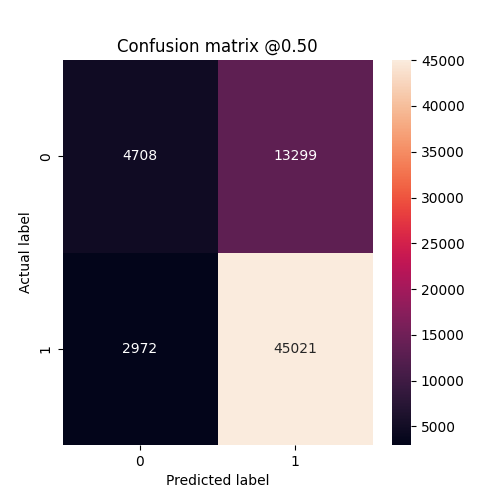

No Flow Detected (True Negatives):  4708
Flow Incorrectly Detected (False Positives):  13299
No Flow Incorrectly Detected (False Negatives):  2972
Flow Detected (True Positives):  45021
Total Flow Detected:  47993
0.753469696969697


In [27]:
balanced_model.plot_cm()

## Let's try again

In [28]:
balanced_model = Model(name = "Balanced Model2", num_classes = 2)

balanced_model.split_transform_data(powder_balanced_df)

balanced_model.apply_StandardScaler()

train_x = balanced_model.train_features
## input layer 
input_layer = keras.Input(shape=(train_x.shape[1],))

## encoding part
encoded = keras.layers.Dense(100, activation='tanh', activity_regularizer=keras.regularizers.l1(10e-5))(input_layer)
encoded = keras.layers.Dense(50, activation='relu')(encoded)

## decoding part
decoded = keras.layers.Dense(50, activation='tanh')(encoded)
decoded = keras.layers.Dense(100, activation='tanh')(decoded)

## output layer
output_layer = keras.layers.Dense(train_x.shape[1], activation='relu')(decoded)

Training labels shape: (211200,)
Validation labels shape: (52800,)
Test labels shape: (66000,)
Training features shape: (211200, 27)
Validation features shape: (52800, 27)
Test features shape: (66000, 27)


In [29]:
from keras.models import Model, Sequential

autoencoder = Model(input_layer, output_layer)
autoencoder.compile(optimizer="adadelta", loss="mse")

In [30]:
x = cleaned_df.drop(["Flow Class"], axis=1)
y = cleaned_df["Flow Class"].values
x_scale = MinMaxScaler().fit_transform(x.values)
x_norm, x_fraud = x_scale[y == 0], x_scale[y == 1]
x

,Da,Dp,FWidth,FLength,ELength,EWidth,Volume,Area,Perimeter,CHull Area,CHull Perimeter,Sphericity,Compactness,Roundness,Ellipse Ratio,Circularity,Solidity,Concavity,Convexity,Extent,Transparency,Curvature,Surface Area,L/W Ratio,W/L Aspect Ratio,CHull Surface Area,Ellipticity
0,31.076,34.663,27.644,35.973,34.802,27.871,15712.926,758.453,108.897,803.897,103.139,0.897,0.864,0.746,0.801,0.804,0.943,0.057,0.947,0.763,0.318,0.0,3033.813,1.301,0.768,3215.587,1.249
1,27.162,29.344,27.434,28.583,27.432,26.912,10492.573,579.445,92.187,602.148,87.799,0.926,0.950,0.903,0.981,0.857,0.962,0.038,0.952,0.739,0.329,0.0,2317.780,1.042,0.960,2408.590,1.019
2,27.239,29.955,27.099,29.289,28.443,26.148,10582.306,582.744,94.107,611.136,88.773,0.909,0.930,0.865,0.919,0.827,0.954,0.046,0.943,0.734,0.336,0.0,2330.975,1.081,0.925,2444.545,1.088
3,33.260,38.347,27.040,44.811,45.210,25.836,19265.652,868.854,120.471,930.055,116.662,0.867,0.742,0.551,0.571,0.752,0.934,0.066,0.968,0.717,0.280,0.0,3475.415,1.657,0.603,3720.222,1.750
4,28.584,30.520,26.918,31.386,30.804,26.592,12228.183,641.700,95.881,666.650,92.672,0.937,0.911,0.829,0.863,0.877,0.963,0.037,0.967,0.760,0.321,0.0,2566.800,1.166,0.858,2666.602,1.158
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271428,3.482,3.924,3.218,4.275,3.876,2.981,22.097,9.520,12.328,10.204,12.226,0.887,0.814,0.663,0.769,0.787,0.933,0.067,0.992,0.692,0.449,0.0,38.081,1.328,0.753,40.815,1.300
271429,3.459,4.264,3.532,4.816,4.121,3.167,21.665,9.396,13.395,10.177,13.356,0.811,0.718,0.516,0.768,0.658,0.923,0.077,0.997,0.552,0.459,0.0,37.583,1.363,0.733,40.708,1.301
271430,3.403,3.871,3.314,4.106,3.789,2.953,20.627,9.093,12.161,9.871,12.011,0.879,0.829,0.687,0.779,0.773,0.921,0.079,0.988,0.668,0.450,0.0,36.373,1.239,0.807,39.485,1.283
271431,3.398,4.532,3.888,4.532,3.881,3.094,20.549,9.070,14.237,11.551,13.657,0.750,0.750,0.562,0.797,0.562,0.785,0.215,0.959,0.515,0.431,0.0,36.281,1.166,0.858,46.203,1.255


In [31]:
autoencoder.fit(x_norm, x_norm, 
                batch_size = 256, epochs = 20, 
                shuffle = True, validation_split = 0.20);

Epoch 1/20
375/375 [==============================] - 1s 2ms/step - loss: 0.2034 - val_loss: 0.1787
Epoch 2/20
375/375 [==============================] - 1s 1ms/step - loss: 0.1747 - val_loss: 0.1523
Epoch 3/20
375/375 [==============================] - 1s 1ms/step - loss: 0.1452 - val_loss: 0.1209
Epoch 4/20
375/375 [==============================] - 1s 1ms/step - loss: 0.1093 - val_loss: 0.0925
Epoch 5/20
375/375 [==============================] - 1s 1ms/step - loss: 0.0870 - val_loss: 0.0789
Epoch 6/20
375/375 [==============================] - 1s 1ms/step - loss: 0.0768 - val_loss: 0.0733
Epoch 7/20
375/375 [==============================] - 1s 1ms/step - loss: 0.0727 - val_loss: 0.0713
Epoch 8/20
375/375 [==============================] - 1s 1ms/step - loss: 0.0713 - val_loss: 0.0707
Epoch 9/20
375/375 [==============================] - 1s 1ms/step - loss: 0.0708 - val_loss: 0.0705
Epoch 10/20
375/375 [==============================] - 1s 1ms/step - loss: 0.0707 - val_loss: 0.0704

In [32]:
hidden_representation = Sequential()
hidden_representation.add(autoencoder.layers[0])
hidden_representation.add(autoencoder.layers[1])
hidden_representation.add(autoencoder.layers[2])

In [33]:
print(x_norm.shape)
print(x_fraud.shape)
norm_hid_rep = hidden_representation.predict(x_norm[:10000])
fraud_hid_rep = hidden_representation.predict(x_fraud[:10000])
# norm_hid_rep = hidden_representation.predict(x_norm)
# fraud_hid_rep = hidden_representation.predict(x_fraud)

(119983, 27)
(151450, 27)


In [34]:
from sklearn.manifold import TSNE
import matplotlib.animation as animation

def tsne_plot(x1, y1, name="graph.png"):
    tsne = TSNE(n_components=3, random_state=0)
    X_t = tsne.fit_transform(x1)
    print(X_t)
    fig = plt.figure()
    
    ax = fig.add_subplot(111, projection='3d')
    ax.view_init(45,60)
    
#     print(X_t[np.where(y1 == 0), 0])
    plot_ = ax.scatter3D(X_t[np.where(y1 == 0), 0], X_t[np.where(y1 == 0), 1], X_t[np.where(y1 == 0), 2], marker='*', cmap='YlOrRd', alpha=0.8, label='No Flow')
    plot_ = ax.scatter3D(X_t[np.where(y1 == 1), 0], X_t[np.where(y1 == 1), 1], X_t[np.where(y1 == 1), 2], marker='o', cmap='BuPu', alpha=0.8, label='Flow')

#     plt.legend(loc='best');
#     plt.savefig(name);
    
    plt.show();
    
    
rep_x = np.append(norm_hid_rep, fraud_hid_rep, axis = 0)
y_n = np.zeros(norm_hid_rep.shape[0])
y_f = np.ones(fraud_hid_rep.shape[0])
rep_y = np.append(y_n, y_f)
print(rep_x.shape)
print(rep_y.shape)
# tsne_plot(rep_x, rep_y, "./latent_representation.png")



(20000, 50)
(20000,)


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


<IPython.core.display.Javascript object>


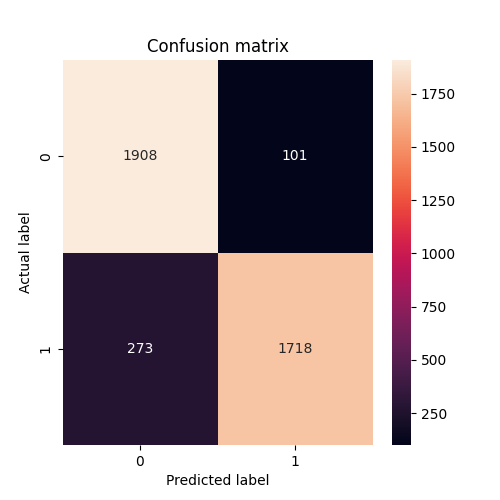

No Flow Detected (True Negatives):  1908
Flow Incorrectly Detected (False Positives):  101
No Flow Incorrectly Detected (False Negatives):  273
Flow Detected (True Positives):  1718
Total Flow Detected:  1991
0.9065


In [35]:
from sklearn.linear_model import LogisticRegression

train_x, val_x, train_y, val_y = train_test_split(rep_x, rep_y, test_size=0.2)

clf = LogisticRegression(solver="lbfgs").fit(train_x, train_y)
pred_y = clf.predict(val_x)

# print ("")
# print ("Classification Report: ")
# print (classification_report(val_y, pred_y))

# print ("")
# print ("Accuracy Score: ", accuracy_score(val_y, pred_y))

cm = confusion_matrix(val_y, pred_y)
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

print('No Flow Detected (True Negatives): ', cm[0][0])
print('Flow Incorrectly Detected (False Positives): ', cm[0][1])
print('No Flow Incorrectly Detected (False Negatives): ', cm[1][0])
print('Flow Detected (True Positives): ', cm[1][1])
print('Total Flow Detected: ', np.sum(cm[1]))
print((cm[0][0] + cm[1][1]) / (cm[0][0] +  cm[0][1] + cm[1][0] +cm[1][1]))

In [36]:
model = keras.Sequential([
          keras.layers.Dense(
              256, activation='tanh',
              input_shape=(train_x.shape[-1],)),
        keras.layers.Dense(
              128, activation='tanh'),
        keras.layers.Dense(
              64, activation='tanh'),
        keras.layers.Dense(
              32, activation='tanh'),
         keras.layers.Dense(
              16, activation='tanh'),
              keras.layers.Dense(
              8, activation='tanh'),
#           keras.layers.Dropout(0.5),
          keras.layers.Dense(1, activation='sigmoid'),
      ])

model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=1e-4),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=['accuracy'])

model.fit(train_x,
    train_y,
    batch_size=1024,
    epochs=100)

results = model.evaluate(train_x, train_y, batch_size = 1024, verbose=0)


Epoch 1/100
16/16 [==============================] - 1s 4ms/step - loss: 0.7121 - accuracy: 0.5052
Epoch 2/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6875 - accuracy: 0.5356
Epoch 3/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6791 - accuracy: 0.6016
Epoch 4/100
16/16 [==============================] - 0s 5ms/step - loss: 0.6712 - accuracy: 0.6171
Epoch 5/100
16/16 [==============================] - 0s 5ms/step - loss: 0.6622 - accuracy: 0.6311
Epoch 6/100
16/16 [==============================] - 0s 5ms/step - loss: 0.6528 - accuracy: 0.6281
Epoch 7/100
16/16 [==============================] - 0s 5ms/step - loss: 0.6428 - accuracy: 0.6369
Epoch 8/100
16/16 [==============================] - 0s 5ms/step - loss: 0.6331 - accuracy: 0.6431
Epoch 9/100
16/16 [==============================] - 0s 5ms/step - loss: 0.6219 - accuracy: 0.6597
Epoch 10/100
16/16 [==============================] - 0s 5ms/step - loss: 0.6092 - accuracy: 0.6718
Epoch 11/

Epoch 83/100
16/16 [==============================] - 0s 7ms/step - loss: 0.2094 - accuracy: 0.9350
Epoch 84/100
16/16 [==============================] - 0s 7ms/step - loss: 0.2170 - accuracy: 0.9311
Epoch 85/100
16/16 [==============================] - 0s 7ms/step - loss: 0.2138 - accuracy: 0.9317
Epoch 86/100
16/16 [==============================] - 0s 7ms/step - loss: 0.2125 - accuracy: 0.9327
Epoch 87/100
16/16 [==============================] - 0s 7ms/step - loss: 0.2126 - accuracy: 0.9312
Epoch 88/100
16/16 [==============================] - 0s 7ms/step - loss: 0.2133 - accuracy: 0.9329
Epoch 89/100
16/16 [==============================] - 0s 7ms/step - loss: 0.2180 - accuracy: 0.9295
Epoch 90/100
16/16 [==============================] - 0s 7ms/step - loss: 0.2106 - accuracy: 0.9335
Epoch 91/100
16/16 [==============================] - 0s 7ms/step - loss: 0.2092 - accuracy: 0.9342
Epoch 92/100
16/16 [==============================] - 0s 6ms/step - loss: 0.2121 - accuracy: 0.9319


[[0.048]
 [0.955]
 [0.956]
 ...
 [0.05 ]
 [0.956]
 [0.938]]


<IPython.core.display.Javascript object>


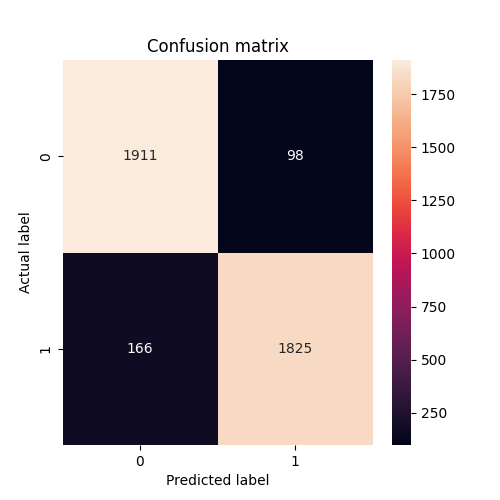

No Flow Detected (True Negatives):  1911
Flow Incorrectly Detected (False Positives):  98
No Flow Incorrectly Detected (False Negatives):  166
Flow Detected (True Positives):  1825
Total Flow Detected:  1991
0.934


In [37]:
pred_y = model.predict(val_x)
print(pred_y)

cm = confusion_matrix(val_y, pred_y > 0.5)
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

print('No Flow Detected (True Negatives): ', cm[0][0])
print('Flow Incorrectly Detected (False Positives): ', cm[0][1])
print('No Flow Incorrectly Detected (False Negatives): ', cm[1][0])
print('Flow Detected (True Positives): ', cm[1][1])
print('Total Flow Detected: ', np.sum(cm[1]))
print((cm[0][0] + cm[1][1]) / (cm[0][0] +  cm[0][1] + cm[1][0] +cm[1][1]))

In [38]:
import kerastuner as kt

def model_builder1(hp):
    # Initialize the Sequential API and start stacking the layers
#     model = keras.Sequential()
#     model.add(keras.layers.Flatten(input_shape=(27,)))
#     # Tune the number of units in the first Dense layer
#     # Choose an optimal value between 32-512
#     hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
#     model.add(keras.layers.Dense(units=hp_units, activation='relu', name='dense_1'))
#     # Add next layers
#     model.add(keras.layers.Dropout(0.2))
#     model.add(keras.layers.Dense(10, activation='softmax'))
#     # Tune the learning rate for the optimizer
#     # Choose an optimal value from 0.01, 0.001, or 0.0001
#     hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
#     model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
#                 loss=keras.losses.SparseCategoricalCrossentropy(),
#                 metrics=['accuracy'])
    model = keras.Sequential([
          keras.layers.Dense(
              256, activation=hp.Choice('act_0', ['relu', 'sigmoid', 'tanh']),
              input_shape=(train_x.shape[-1],)),
        keras.layers.Dense(
              128, activation=hp.Choice('act_1', ['relu', 'sigmoid', 'tanh'])),
        keras.layers.Dense(
              64, activation=hp.Choice('act_2', ['relu', 'sigmoid', 'tanh'])),
        keras.layers.Dense(
              32, activation=hp.Choice('act_3', ['relu', 'sigmoid', 'tanh'])),
         keras.layers.Dense(
              16, activation=hp.Choice('act_4', ['relu', 'sigmoid', 'tanh'])),
              keras.layers.Dense(
              8, activation=hp.Choice('act_5', ['relu', 'sigmoid', 'tanh'])),
#           keras.layers.Dropout(0.5),
          keras.layers.Dense(1, activation=hp.Choice('act_6', ['relu', 'sigmoid', 'tanh']))
              ])
    model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=['accuracy'])
    return model

/var/folders/g0/2kyy4qns4bd0bxf360q9g7fm0000gn/T/ipykernel_41069/1373958943.py:1: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt


In [43]:
# Instantiate the tuner
tuner = kt.Hyperband(model_builder1, # the hypermodel
                     objective='val_accuracy', # objective to optimize
                        max_epochs=20,
                        factor=3, # factor which you have seen above 
                        directory='dir/fin', # directory to save logs 
                        project_name='hyperband')

# hypertuning settings
tuner.search_space_summary() 

Search space summary
Default search space size: 8
act_0 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'sigmoid', 'tanh'], 'ordered': False}
act_1 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'sigmoid', 'tanh'], 'ordered': False}
act_2 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'sigmoid', 'tanh'], 'ordered': False}
act_3 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'sigmoid', 'tanh'], 'ordered': False}
act_4 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'sigmoid', 'tanh'], 'ordered': False}
act_5 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'sigmoid', 'tanh'], 'ordered': False}
act_6 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'sigmoid', 'tanh'], 'ordered': False}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [44]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
# Perform hypertuning
tuner.search(train_x, train_y, epochs=10, validation_split=0.2, callbacks=[stop_early])

Trial 30 Complete [00h 00m 15s]
val_accuracy: 0.9262499809265137

Best val_accuracy So Far: 0.9315624833106995
Total elapsed time: 00h 02m 39s
INFO:tensorflow:Oracle triggered exit


In [45]:
best_hp=tuner.get_best_hyperparameters()[0]# Build the model with the optimal hyperparameters

In [ ]:
h_model = tuner.hypermodel.build(best_hp)
h_model.summary()
h_model.fit(train_x, train_y, epochs=50, validation_split=0.2)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 256)               13056     
                                                                 
 dense_8 (Dense)             (None, 128)               32896     
                                                                 
 dense_9 (Dense)             (None, 64)                8256      
                                                                 
 dense_10 (Dense)            (None, 32)                2080      
                                                                 
 dense_11 (Dense)            (None, 16)                528       
                                                                 
 dense_12 (Dense)            (None, 8)                 136       
                                                                 
 dense_13 (Dense)            (None, 1)                

In [ ]:
h_eval_dict = h_model.evaluate(val_x, val_y, return_dict=True)

In [ ]:
pred_y = h_model.predict(val_x)
print(pred_y)

cm = confusion_matrix(val_y, pred_y > 0.5)
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

print('No Flow Detected (True Negatives): ', cm[0][0])
print('Flow Incorrectly Detected (False Positives): ', cm[0][1])
print('No Flow Incorrectly Detected (False Negatives): ', cm[1][0])
print('Flow Detected (True Positives): ', cm[1][1])
print('Total Flow Detected: ', np.sum(cm[1]))
print((cm[0][0] + cm[1][1]) / (cm[0][0] +  cm[0][1] + cm[1][0] +cm[1][1]))